THINGS TO CHECK
- check rescale
- load on demand vs load on init

In [27]:
import sys
sys.path.append('../src')

import albumentations as A
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *

In [2]:
torch.cuda.is_available()

True

In [3]:
model_card = "shi-labs/oneformer_coco_dinat_large"
# model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, is_training=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_dinat_large and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [4]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [5]:
MAIN_PROJECT_DIR

'/home/panzaresce/repos/galaxy_segmentation'

In [5]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [6]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)

In [7]:
dataset_val = GalaxyDataset(DATASET_DIR, "val", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)

In [8]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)

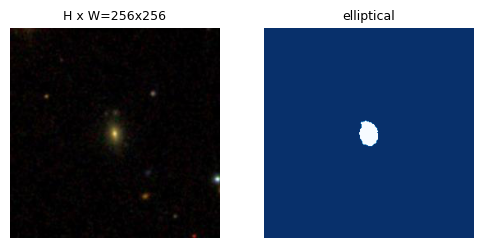

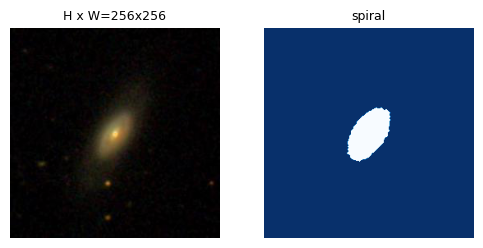

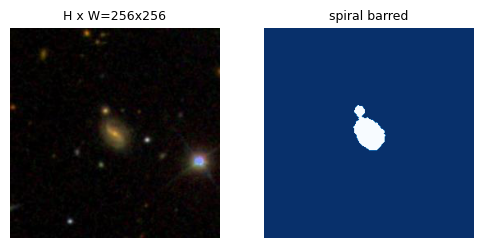

In [79]:
display_n_samples(dataset_train, 3)

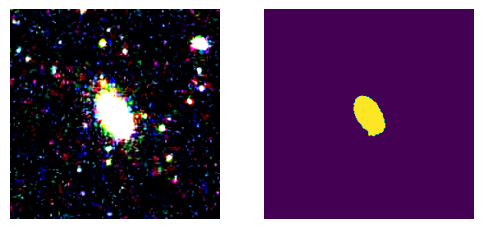

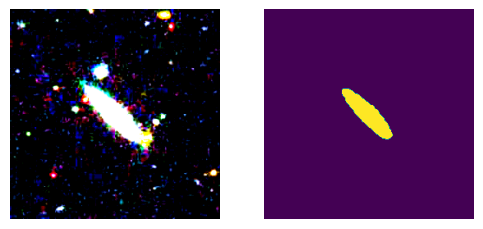

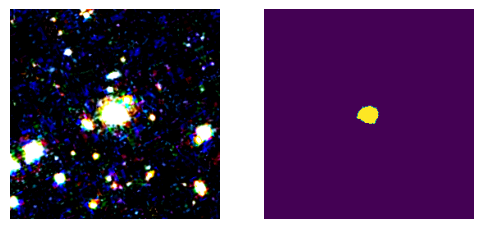

In [78]:
display_n_samples(dataset_train, 3, False)

In [10]:
batch_size = 4
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
n_epochs = 2
optimizer = AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"


model.train()
model.model.is_training = True
model.to(device)
for epoch in range(n_epochs):  # loop over the dataset multiple times
  print(f"Epoch {epoch+1}")
  running_loss = 0.0
  for batch_idx, batch in enumerate(train_dataloader):

      # zero the parameter gradients
      optimizer.zero_grad()

      batch = {k:v.to(device) for k,v in batch.items()}
      # forward pass
      outputs = model(**batch)

      running_loss += outputs.loss.item()
      if (batch_idx + 1) % (len(train_dataloader) // 20) == 0 or batch_idx < 10:
        avg_loss = running_loss / (batch_idx + 1)
        print(f"Avg loss at iteration n. {(batch_idx + 1)} / {len(train_dataloader)}: {avg_loss}")

      outputs.loss.backward()
      optimizer.step()

In [ ]:
model.eval()
model.model.is_training = False

image = Image.open(dataset_test.image_info[2]["path"])
inputs = processor(images=image, task_inputs=["instance"], return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [ ]:
semantic_segmentation = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]